# Preliminary Steps

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
nltk.download('stopwords')
import string
from torchtext.data.utils import get_tokenizer
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/willdemelo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/willdemelo/custkernel/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/willdemelo/custkernel/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    a

In [2]:
df = pd.read_csv('fake_job_postings.csv')
df.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


# Data Cleaning

In [3]:
def preprocessor(sentences):

    # Necessary steps - calls specific items used for preprocessing functions
    processed_sentences = []
    translator = str.maketrans('', '', string.punctuation)
    tokenizer = get_tokenizer("basic_english")
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    # Preprocessing steps (non-essential steps can be removed)
    for sentence in sentences:

        # Turns all words lowercase
        sentence = sentence.lower()

        # Removes punctuation
        pl_sentence = sentence.translate(translator)

        # Tokenizes sentence
        tokens = tokenizer(pl_sentence)

        # Removes stopwords
        sw_tokens = [token for token in tokens if token not in stop_words]

        # # Stems words
        # st_tokens = [stemmer.stem(token) for token in sw_tokens]

        # # Removes uncommon words
        # freq_dist = FreqDist(tokens)
        # threshold = 1
        # fq_tokens = [token for token in tokens if freq_dist[token] > threshold]

        processed_sentences.append(" ".join(sw_tokens))
    return processed_sentences

In [4]:
# Remove duplicates
df = df.drop_duplicates()

# # Get salary data: range (distance between proposed salaries) and average (mean of proposed salaries)
# salary = []
# for item in df['salary_range']:
#     try:
#         x = item.split("-")
#         x[0] = int(x[0])
#         x[1] = int(x[1])
#         salary.append(x)
#     except:
#         salary.append([np.nan, np.nan])
# # Range variable
# salary_rng = []
# # Average variable
# salary_avg = []
# for item in salary:
#     try:
#         salary_rng.append(abs(item[0]-item[1]))
#         salary_avg.append((item[0]+item[1])/2)
#     except:
#         salary_rng.append(np.nan)
#         salary_avg.append(np.nan)
# df['salary_rng'] = salary_rng
# df['salary_avg'] = salary_avg

# Get country variable: country denoted in job posting:
countries = []
for item in df['location']:
    try:
        countries.append(item.split(",")[0])
    except:
        countries.append(np.nan)
df['country'] = countries

# Clean text data
text_features = ['title', 'description', 'company_profile', 'requirements', 'benefits']
for item in text_features:
    df[item] = df[item].fillna('')
    df[item] = preprocessor(df[item])

# Clean categorical data
categorical_features = ['country', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']
for item in categorical_features:
    df[item] = df[item].fillna('Unknown')
    df[item] = [entry.lower() for entry in df[item]]

In [5]:
# Drop unnecessary columns
drop_columns = ['job_id', 'salary_range', 'location', 'department']
df_sep = df.drop(columns=drop_columns)

print(df_sep.shape)
df_sep.head()


(17880, 15)


,title,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country
0,marketing intern,food52 weve created groundbreaking awardwinnin...,food52 fastgrowing james beard awardwinning on...,experience content management systems major pl...,,0,1,0,other,internship,unknown,unknown,marketing,0,us
1,customer service cloud video production,90 seconds worlds cloud video production servi...,organised focused vibrant awesomedo passion cu...,expect youyour key responsibility communicate ...,get usthrough part 90 seconds team gainexperie...,0,1,0,full-time,not applicable,unknown,marketing and advertising,customer service,0,nz
2,commissioning machinery assistant cma,valor services provides workforce solutions me...,client located houston actively seeking experi...,implement precommissioning commissioning proce...,,0,1,0,unknown,unknown,unknown,unknown,unknown,0,us
3,account executive washington dc,passion improving quality life geography heart...,company esri – environmental systems research ...,education bachelor’s master’s gis business adm...,culture anything corporate—we collaborative cr...,0,1,0,full-time,mid-senior level,bachelor's degree,computer software,sales,0,us
4,bill review manager,spotsource solutions llc global human capital ...,job title itemization review managerlocation f...,qualificationsrn license state texasdiploma ba...,full benefits offered,0,1,1,full-time,mid-senior level,bachelor's degree,hospital & health care,health care provider,0,us


In [6]:
df['text_features'] = df['title'] + df['company_profile'] + df['description'] + df['requirements'] + df['benefits']

drop_columns = ['job_id', 'salary_range', 'location', 'department', 'title', 'company_profile', 'description', 'requirements', 'benefits']
df_concat = df.drop(columns=drop_columns)

categorical_features = ['country', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']

print(df_concat.shape)
df_concat.head()

(17880, 11)


,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,text_features
0,0,1,0,other,internship,unknown,unknown,marketing,0,us,marketing internfood52 weve created groundbrea...
1,0,1,0,full-time,not applicable,unknown,marketing and advertising,customer service,0,nz,customer service cloud video production90 seco...
2,0,1,0,unknown,unknown,unknown,unknown,unknown,0,us,commissioning machinery assistant cmavalor ser...
3,0,1,0,full-time,mid-senior level,bachelor's degree,computer software,sales,0,us,account executive washington dcpassion improvi...
4,0,1,1,full-time,mid-senior level,bachelor's degree,hospital & health care,health care provider,0,us,bill review managerspotsource solutions llc gl...


# Training (Separate Approach)

In [7]:
# Features and target
X = df_sep.drop('fraudulent', axis=1)
y = df_sep['fraudulent']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Training set: (14304, 14)
Testing set: (3576, 14)


In [8]:
# TF-IDF for text
text_transformer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=5, sublinear_tf=True)

# Categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine
preprocessor = ColumnTransformer(
    transformers=[
        ('title_tfidf', text_transformer, 'title'),
        ('desc_tfidf', text_transformer, 'description'),
        ('profile_tfidf', text_transformer, 'company_profile'),
        ('requirements_tfidf', text_transformer, 'requirements'),
        ('benefits_tfidf', text_transformer, 'benefits'),
        ('cat', categorical_transformer, categorical_features),
        ('num', 'passthrough', ['telecommuting', 'has_company_logo', 'has_questions'])
    ],
    remainder='drop'
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................classifier__C=0.01; total time= 6.3min
[CV] END .................................classifier__C=0.01; total time= 6.5min
[CV] END .................................classifier__C=0.01; total time= 6.5min
[CV] END .................................classifier__C=0.01; total time= 6.5min
[CV] END .................................classifier__C=0.01; total time= 6.6min
Best C: 0.01
Best cross-validated F1-score: 0.822114561194536
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.95      0.80      0.87       173

    accuracy                           0.99      3576
   macro avg       0.97      0.90      0.93      3576
weighted avg       0.99      0.99      0.99      3576



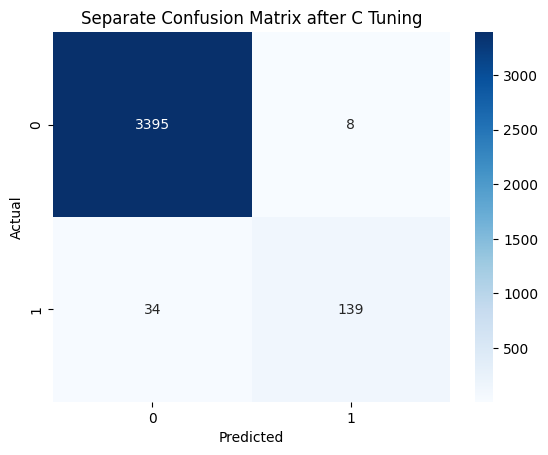

ROC AUC Score: 0.9879


In [9]:
# Define SVM pipeline
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),  # with_mean=False because of sparse TF-IDF
    ('classifier', SVC(kernel='linear', C=3.0, class_weight='balanced', probability=True, random_state=1))
])

# Fit
param_grid = {
    # 'classifier__C': [0.01, 0.1, 1]
    'classifier__C': [0.01]
}

grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Optimize for F1-score
    n_jobs=-1,  # Use all available CPU cores
    verbose=2  # Print progress
)

grid_search.fit(X_train, y_train)

print("Best C:", grid_search.best_params_['classifier__C'])
print("Best cross-validated F1-score:", grid_search.best_score_)

best_model_S = grid_search.best_estimator_

y_pred = best_model_S.predict(X_test)
y_prob = best_model_S.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Separate Confusion Matrix after C Tuning')
plt.show()

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}") 

# # Predict
# y_pred = svm_pipeline.predict(X_test)
# y_prob = svm_pipeline.predict_proba(X_test)[:,1]  # Probability scores for AUC


In [10]:
# # Classification report
# print(classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # ROC AUC Score
# roc_auc = roc_auc_score(y_test, y_prob)
# print(f"ROC AUC Score: {roc_auc:.4f}")


In [11]:
# Calculate precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
print(f"Number of thresholds: {len(thresholds)}")

# F1 scores
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

# Best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {best_f1:.4f}")

Number of thresholds: 3364
Best Threshold: 0.2694
Best F1-Score: 0.8757


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.90      0.86      0.88       173

    accuracy                           0.99      3576
   macro avg       0.94      0.93      0.93      3576
weighted avg       0.99      0.99      0.99      3576



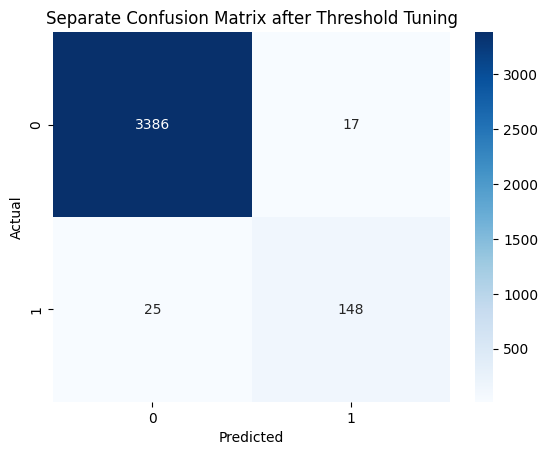

In [12]:
# Apply best threshold
y_pred_threshold = (y_prob >= best_threshold).astype(int)

# Classification report
print(classification_report(y_test, y_pred_threshold))

# Confusion Matrix (Threshold Tuned)
cm_thresh = confusion_matrix(y_test, y_pred_threshold)
sns.heatmap(cm_thresh, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Separate Confusion Matrix after Threshold Tuning')
plt.show()

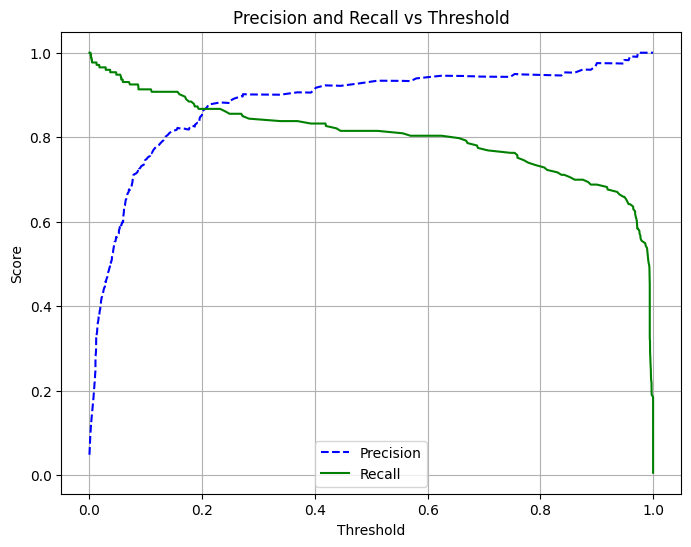

In [13]:
# Plot precision and recall vs threshold
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()

# Training (Combined Approach)

In [14]:
# Features and target
X = df_concat.drop('fraudulent', axis=1)
y = df_concat['fraudulent']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

Training set: (14304, 10)
Testing set: (3576, 10)


In [15]:
# TF-IDF for text
text_transformer2 = TfidfVectorizer(max_features=10000, ngram_range=(1,2), min_df=5, sublinear_tf=True)
categorical_transformer2 = OneHotEncoder(handle_unknown='ignore')

# Combine
preprocessor2 = ColumnTransformer(
    transformers=[
        ('desc_tfidf', text_transformer2, 'text_features'),
        ('cat', categorical_transformer2, categorical_features),
        ('num', 'passthrough', ['telecommuting', 'has_company_logo', 'has_questions'])
    ],
    remainder='drop')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................classifier__C=0.01; total time= 5.0min
[CV] END .................................classifier__C=0.01; total time= 5.1min
[CV] END .................................classifier__C=0.01; total time= 5.1min
[CV] END .................................classifier__C=0.01; total time= 5.1min
[CV] END .................................classifier__C=0.01; total time= 5.1min
Best C: 0.01
Best cross-validated F1-score: 0.8342446200019624
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.91      0.83      0.87       173

    accuracy                           0.99      3576
   macro avg       0.95      0.91      0.93      3576
weighted avg       0.99      0.99      0.99      3576



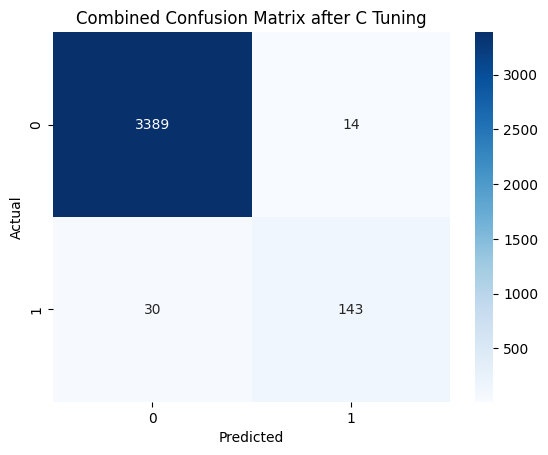

ROC AUC Score: 0.9882


In [16]:
# Define SVM pipeline
svm_pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor2),
    ('scaler', StandardScaler(with_mean=False)),  # with_mean=False because of sparse TF-IDF
    ('classifier', SVC(kernel='linear', C=3.0, class_weight='balanced', probability=True, random_state=1))
])

param_grid = {
    # 'classifier__C': [0.01, 0.1, 1]
    'classifier__C': [0.01]
}

grid_search = GridSearchCV(
    estimator=svm_pipeline2,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Optimize for F1-score
    n_jobs=-1,  # Use all available CPU cores
    verbose=2  # Print progress
)

grid_search.fit(X_train, y_train)

print("Best C:", grid_search.best_params_['classifier__C'])
print("Best cross-validated F1-score:", grid_search.best_score_)

best_model_C = grid_search.best_estimator_

y_pred = best_model_C.predict(X_test)
y_prob = best_model_C.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Combined Confusion Matrix after C Tuning')
plt.show()

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}") 

# # Fit
# svm_pipeline2.fit(X_train, y_train)

# # Predict
# y_pred = svm_pipeline2.predict(X_test)
# y_prob = svm_pipeline2.predict_proba(X_test)[:,1]  # Probability scores for AUC

In [17]:
# # Classification report
# print(classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # ROC AUC Score
# roc_auc = roc_auc_score(y_test, y_prob)
# print(f"ROC AUC Score: {roc_auc:.4f}")

In [18]:
# Calculate precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
print(f"Number of thresholds: {len(thresholds)}")

# F1 scores
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

# Best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {best_f1:.4f}")

Number of thresholds: 3348
Best Threshold: 0.3812
Best F1-Score: 0.8772


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.89      0.87      0.88       173

    accuracy                           0.99      3576
   macro avg       0.94      0.93      0.94      3576
weighted avg       0.99      0.99      0.99      3576



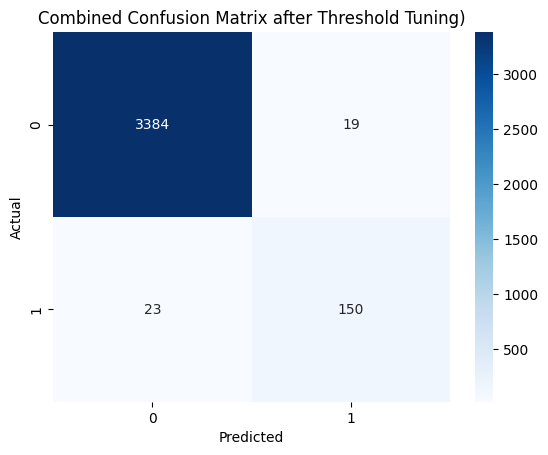

In [19]:
# Apply best threshold
y_pred_threshold = (y_prob >= best_threshold).astype(int)

# Classification report
print(classification_report(y_test, y_pred_threshold))

# Confusion Matrix (Threshold Tuned)
cm_thresh = confusion_matrix(y_test, y_pred_threshold)
sns.heatmap(cm_thresh, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Combined Confusion Matrix after Threshold Tuning)')
plt.show()

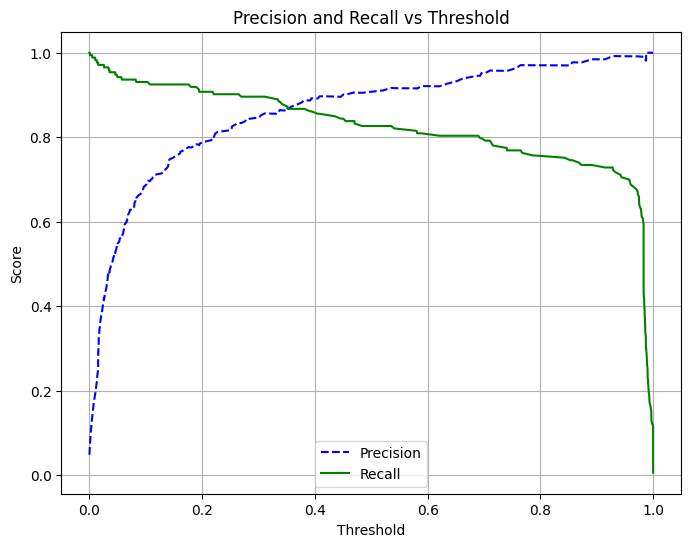

In [20]:
# Plot precision and recall vs threshold
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()

# WordCloud Generation

In [22]:
best_pipe = best_model_C

coefs = best_pipe.named_steps['classifier'].coef_

if hasattr(coefs, "toarray"):
    coefs = coefs.toarray()

coefs = coefs.flatten()

feature_names = best_pipe.named_steps['preprocessor'].get_feature_names_out()

importances = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(coefs)
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

print(importances.head(20))


                              feature  importance
0               num__has_company_logo    0.055210
1            cat__industry_accounting    0.048280
2                 desc_tfidf__website    0.044207
3   cat__function_accounting/auditing    0.034522
4               desc_tfidf__executive    0.030713
5                      desc_tfidf__ux    0.025732
6            desc_tfidf__clients work    0.024850
7   cat__industry_writing and editing    0.024318
8                 desc_tfidf__payroll    0.023687
9                     cat__country_br    0.023276
10               cat__country_unknown    0.023245
11                 desc_tfidf__subsea    0.022607
12               desc_tfidf__american    0.022227
13                     desc_tfidf__pc    0.021977
14    cat__industry_airlines/aviation    0.021545
15                 desc_tfidf__junior    0.019942
16               desc_tfidf__bookings    0.019611
17         desc_tfidf__office manager    0.019540
18                   desc_tfidf__fill    0.019539


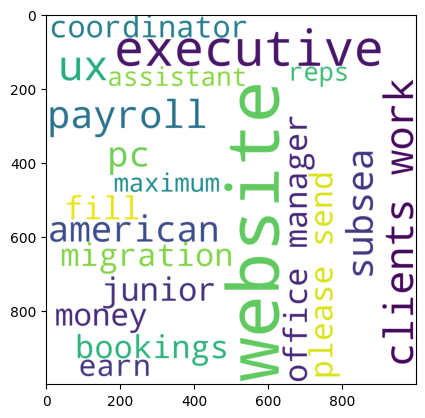

In [23]:
desc = {}

for i, row in importances.iterrows():
    if "desc_tfidf__" in row['feature']:
        desc[row['feature'].replace("desc_tfidf__", "")] = row['importance']
    else:
        pass

cloud = WordCloud(background_color="white",
    width=1000,
    height=1000,
    max_words=20,
    relative_scaling=1,
    normalize_plurals=False).generate_from_frequencies(desc)

plt.imshow(cloud)

In [35]:
from MLstatkit.stats import Delong_test


y_test = df_sep['fraudulent']
y_probS = best_model_S.predict_proba(df_sep)[:, 1]
y_probC = best_model_C.predict_proba(df_concat)[:, 1]

In [36]:
z_score, p_value = Delong_test(y_test, y_probC, y_probS)

print(f"z-score: {z_score}, P-Value: {p_value}")

z-score: -0.0061110185253703455, P-Value: 0.9951241430156244
